In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
from pathlib import Path
import numpy as np
import h5py
from tqdm.auto import tqdm, trange
import scipy.io
import time
import torch
import random
import math
import shutil
from sklearn.decomposition import PCA
import scipy as sp
import scipy.signal
import os
import pandas as pd
from torch import nn
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score

from analysis.proj import learn_manifold_umap, pca_train, pca
from analysis.plotting import plot_gmm
from analysis.contrastive_utils import get_enc_backbone, get_fcenc_backbone, get_ckpt_results
from analysis.cluster import GMM, HDBSCAN
from analysis.benchmarking import class_scores, avg_score, per_class_accs, avg_class_accs

from spike_psvae.denoise import SingleChanDenoiser

In [3]:
import matplotlib.pyplot as plt
# %matplotlib inline
plt.rc("figure", dpi=100)
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=SMALL_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

## Load Data

In [4]:
import MEArec as mr
data_base_dir = Path('/moto/stats/users/ch3676/datasets_contrastive_ephys/')
data_type = Path('single_channel/DY016_random_neurons/')
data_name = Path('dy016_random_neurons_04_28_2023')
data_path = data_base_dir / data_type / data_name

In [5]:
unit_ids = np.load(data_path / 'unit_ids.npy')
spikes_train = np.load(data_path / 'spikes_train.npy')
spikes_test = np.load(data_path / 'spikes_test.npy')
labels_test = np.load(data_path / 'labels_test.npy')
labels_train = np.load(data_path / 'labels_train.npy')
selected_units = np.load(data_path / 'selected_units.npy')

## Set PCA params

In [6]:
if len(spikes_train.shape) == 2:
    print("single channel waveforms")
    num_chan_pca = 1
else:
    print("multi-chanel waveforms")
    num_chan_pca = 3

single channel waveforms


## Denoise

In [7]:
denoised_wfs_train = []
denoised_wfs_test = []

wfs_train = spikes_train.copy()
wfs_test = spikes_test.copy()

denoiser = SingleChanDenoiser()
denoiser.load('/moto/home/ch3676/spike-psvae/pretrained/single_chan_denoiser.pt')

for i in range(len(wfs_train)):
    curr_wf = wfs_train[i]
    with torch.no_grad():
        curr_wf = torch.unsqueeze(torch.from_numpy(curr_wf), dim=0)
        den_wf = denoiser(curr_wf)
        denoised_wfs_train.append(den_wf.squeeze().numpy())

denoised_wfs_train = np.array(denoised_wfs_train)
    
for i in range(len(wfs_test)):
    curr_wf = wfs_test[i]
    with torch.no_grad():
        curr_wf = torch.unsqueeze(torch.from_numpy(curr_wf), dim=0)
        den_wf = denoiser(curr_wf)
        denoised_wfs_test.append(den_wf.squeeze().numpy())

In [8]:
wfs_train_mean = np.mean(np.array([wf.flatten() for wf in wfs_train]), axis=0)
wfs_train_norm = np.array([wf.flatten() for wf in wfs_train]) - wfs_train_mean
wfs_test_norm = np.array([wf.flatten() for wf in wfs_test]) - wfs_train_mean

denoised_wfs_train_mean = np.mean(np.array([wf.flatten() for wf in denoised_wfs_train]), axis=0)
denoised_wfs_train_norm = np.array([wf.flatten() for wf in denoised_wfs_train]) - denoised_wfs_train_mean
denoised_wfs_test_norm = np.array([wf.flatten() for wf in denoised_wfs_test]) - denoised_wfs_train_mean


n_comps = 10
std_scale = 1
pcs_train, _, _ = pca(wfs_train_norm, n_comps) * std_scale
pcs_test, pcs_ex_var  = pca_train(wfs_train_norm, wfs_test_norm, n_comps) * std_scale
denoised_pcs_train, _, _  = pca(denoised_wfs_train_norm, n_comps) * std_scale
denoised_pcs_test, denoised_pcs_ex_var = pca_train(denoised_wfs_train_norm, denoised_wfs_test_norm, n_comps) * std_scale

train done
pca test done
train done
pca test done


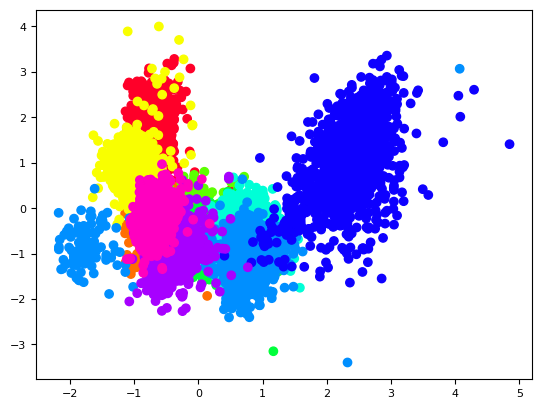

In [9]:
plt.scatter(denoised_pcs_train[:,0], denoised_pcs_train[:,1], c=labels_train, cmap='gist_rainbow');

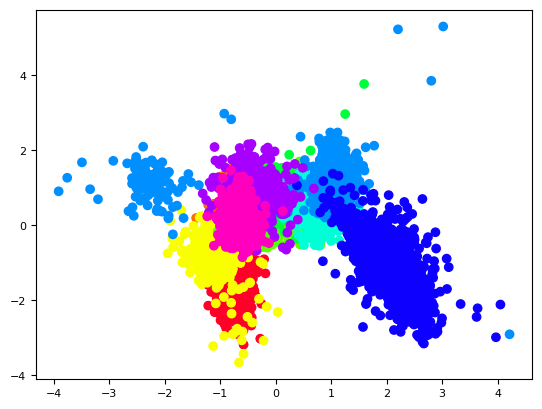

In [10]:
plt.scatter(pcs_train[:,0], pcs_train[:,1], c=labels_train, cmap='gist_rainbow');

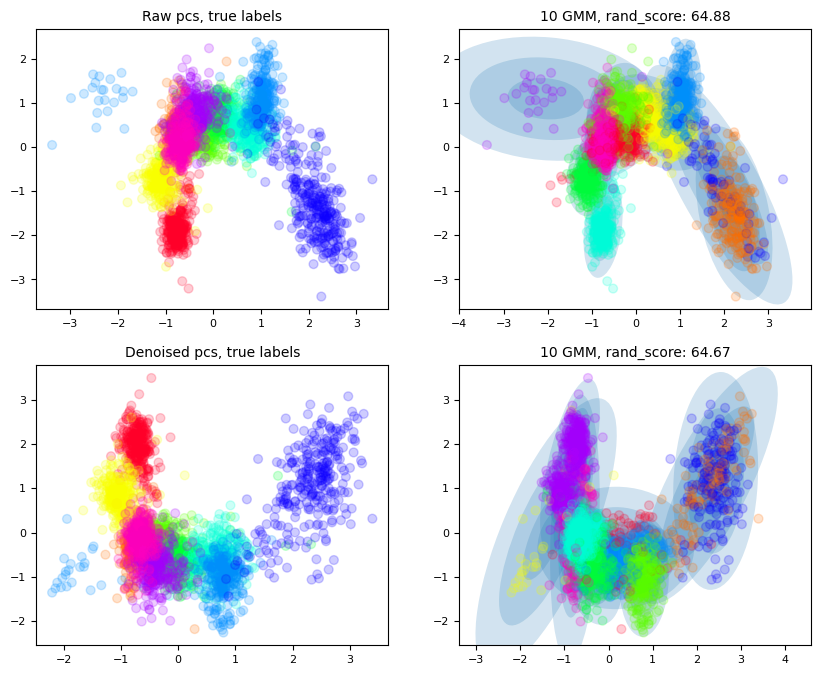

In [13]:
reps_train = pcs_train
reps_test = pcs_test

num_components = 5
covariance_type = 'full'
n_clusters = 10
pc_gmm = GaussianMixture(n_clusters, 
                         random_state=0, 
                         covariance_type=covariance_type).fit(reps_train[:,:num_components])
pc_test_labels = pc_gmm.predict(reps_test[:,:num_components])


reps_train = denoised_pcs_train
reps_test = denoised_pcs_test

num_components = 5
covariance_type = 'full'
n_clusters = 10
denoised_pc_gmm = GaussianMixture(n_clusters, 
                                  random_state=0, 
                                  covariance_type=covariance_type).fit(reps_train[:,:num_components])
denoised_pc_test_labels = denoised_pc_gmm.predict(reps_test[:,:num_components])

fig, axes = plt.subplots(2,2,figsize=(10,8))
X = pcs_test[:,:num_components]
score = adjusted_rand_score(labels_test, pc_test_labels)*100
row = 0
gmm = pc_gmm
axes[row][0].scatter(X[:, 0], X[:, 1], c=labels_test, s=40, cmap='gist_rainbow', zorder=2, alpha=.2)
plot_gmm(gmm, X, label=True, ax=axes[row][1])
axes[row][0].set_title('Raw pcs, true labels')
axes[row][1].set_title(f'10 GMM, rand_score: {np.round(score,2)}');

X = denoised_pcs_test[:,:num_components]
score = adjusted_rand_score(labels_test, denoised_pc_test_labels)*100
row = 1
gmm = denoised_pc_gmm
axes[row][0].scatter(X[:, 0], X[:, 1], c=labels_test, s=40, cmap='gist_rainbow', zorder=2, alpha=.2)
plot_gmm(gmm, X, label=True, ax=axes[row][1])
axes[row][0].set_title('Denoised pcs, true labels')
axes[row][1].set_title(f'10 GMM, rand_score: {np.round(score,2)}');

In [29]:
from models.model_GPT import GPT, GPTConfig
#change params based on checkpoint
GPTConfig.out_dim = 5
GPTConfig.proj_dim = 5 
GPTConfig.n_embd = 32
GPTConfig.n_head = 4
GPTConfig.block_size = 121
GPTConfig.bias = False
GPTConfig.n_layer = 20
GPTConfig.is_causal = True

#use reps or projections
use_reps = False

#choose model class
model = GPT(GPTConfig)

#load checkpoint
path_to_checkpoint = Path('/moto/stats/users/ch3676/spike_contrastive_models_0501/0501out_dim5proj_dim5batch-size512lr0.001epochs800fp16use_gptis_causaln_embd32')
checkpoint_path = path_to_checkpoint / 'checkpoint.pth'
checkpoint = torch.load(checkpoint_path, map_location="cpu")
state_dict = checkpoint["state_dict"]
sd_keys = state_dict.keys()
state_dict_final = {k:state_dict[k] for k in sd_keys if not k.endswith('.attn.bias')}
model.load_state_dict(state_dict_final)
if use_reps:
    model.projector = nn.Identity()
    model.online_head = nn.Identity()
model.eval() ; 

Using projector; batchnorm False with depth 3; hidden_dim=512
number of parameters: 0.52M


In [30]:
wfs_train_torch = torch.from_numpy(wfs_train[:,:,None])
wfs_train_cont = model(wfs_train_torch)
wfs_train_cont_numpy = wfs_train_cont.detach().numpy()
del wfs_train_cont

wfs_test_torch = torch.from_numpy(wfs_test[:,:,None])
wfs_test_cont = model(wfs_test_torch)
wfs_test_cont_numpy = wfs_test_cont.detach().numpy()
del wfs_test_cont

In [31]:
wfs_train_cont_numpy.shape

(12000, 5)

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set(font_scale=1.3)

In [33]:
from sklearn.mixture import GaussianMixture
import hdbscan
import numpy as np
from sklearn.metrics import adjusted_rand_score

# covariance_type : {'full', 'tied', 'diag', 'spherical'}
# reps_train = pcs_train
# reps_test = pcs_test
covariance_type = 'full'
n_clusters = 10
reps_train = wfs_train_cont_numpy
reps_test = wfs_test_cont_numpy
gmm_list_cont = []
num_components = np.arange(5, reps_train.shape[1]+1)
for num_c in num_components:
    gmm = GaussianMixture(n_clusters, 
                          random_state=0, 
                          covariance_type=covariance_type).fit(reps_train[:,:num_c])
    gmm_list_cont.append(gmm)
    gmm_cont_test_labels = gmm.predict(reps_test[:,:num_c])
    score = adjusted_rand_score(labels_test, gmm_cont_test_labels)*100
    print(f"num_comps: {num_c}, rand_score: {score}")

num_comps: 5, rand_score: 86.59857684146249


In [34]:
pcs_train_cont, _, _ = pca(wfs_train_cont_numpy, n_comps=2)
pcs_test_cont, pcs_ex_var  = pca_train(wfs_train_cont_numpy, wfs_test_cont_numpy, n_comps=2)

train done
pca test done


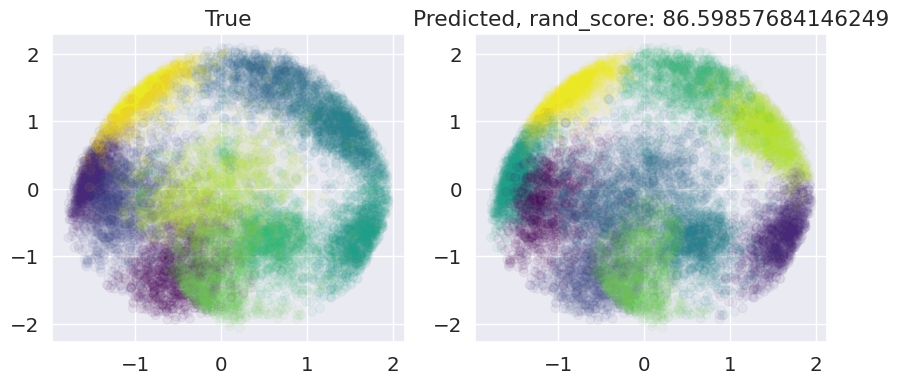

In [35]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
X = pcs_train_cont
gmm = gmm_list_cont[0]
train_labels = gmm.predict(wfs_train_cont_numpy)
axes[0].scatter(X[:, 0], X[:, 1], c=labels_train, s=40, cmap='viridis', zorder=2, alpha=.05)
axes[1].scatter(X[:, 0], X[:, 1], c=train_labels, s=40, cmap='viridis', zorder=2, alpha=.05)
# plot_gmm(gmm, wfs_train_cont_numpy, label=True, ax=axes[1])
gmm_cont_test_labels = gmm.predict(wfs_test_cont_numpy)
score = adjusted_rand_score(labels_test, gmm_cont_test_labels)*100
axes[0].set_title('True')
axes[1].set_title(f'Predicted, rand_score: {score}');

In [36]:
from analysis.cluster import MeanShift

In [37]:
# clustering = MeanShift(bandwidth=2, n_jobs=20).fit(wfs_test_cont_numpy)
# labels_test_ms = clustering.predict(wfs_test_cont_numpy)
# score = adjusted_rand_score(labels_test, labels_test_ms)*100

In [38]:
cont_test_umap = learn_manifold_umap(wfs_test_cont_numpy, umap_dim=2, umap_min_dist=0.2, umap_metric='euclidean', umap_neighbors=10)
clustering = MeanShift(bandwidth=2, n_jobs=20).fit(cont_test_umap)
labels_test_ms = clustering.predict(cont_test_umap)
score = adjusted_rand_score(labels_test, labels_test_ms)*100
print(score)

number of seeds: 3000
seeds/job: 151
using 20 cpus


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:  2.4min remaining: 13.4min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:  2.4min remaining:  1.0min


predicting
87.20003102884782


[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  2.4min finished


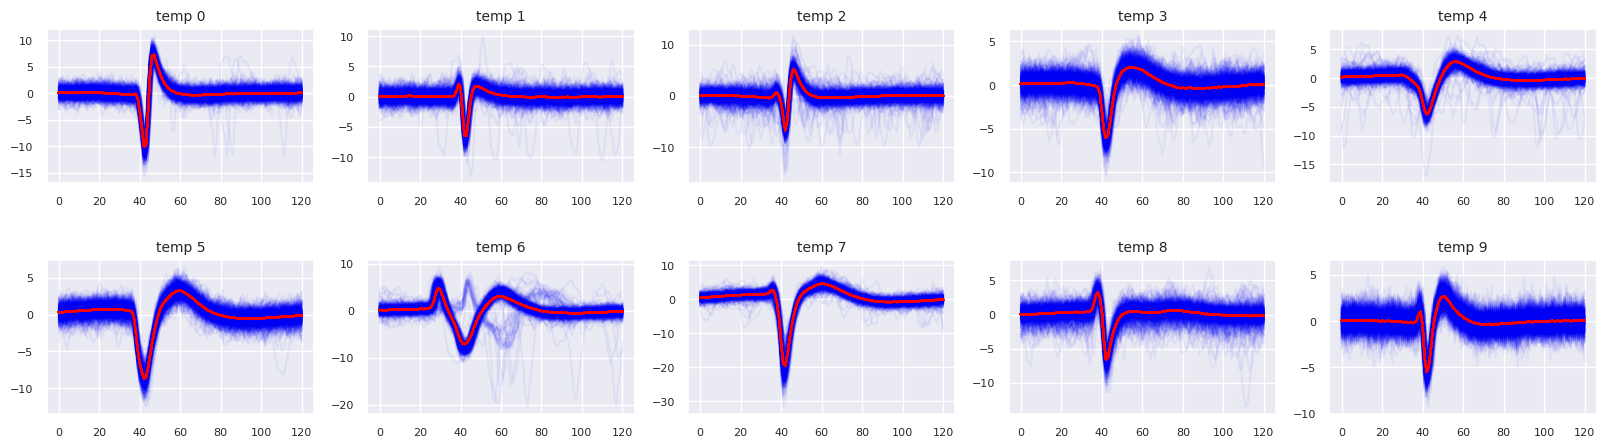

In [147]:
num_plot = 400
fig, axes = plt.subplots(2,5,figsize=(20,5))
for label_plot in range(len(np.unique(labels_train))):
    ax = axes[label_plot // 5][label_plot % 5]
    spikes = wfs_train[np.where(labels_train==label_plot)]
    for spike in spikes[:num_plot]:
        ax.plot(spike.flatten(), color='blue', alpha=.05)
        ax.plot(np.mean(spikes, 0).flatten(), color='red')
    ax.set_title(f'temp {label_plot}')
fig.subplots_adjust(hspace=0.5)
plt.show()

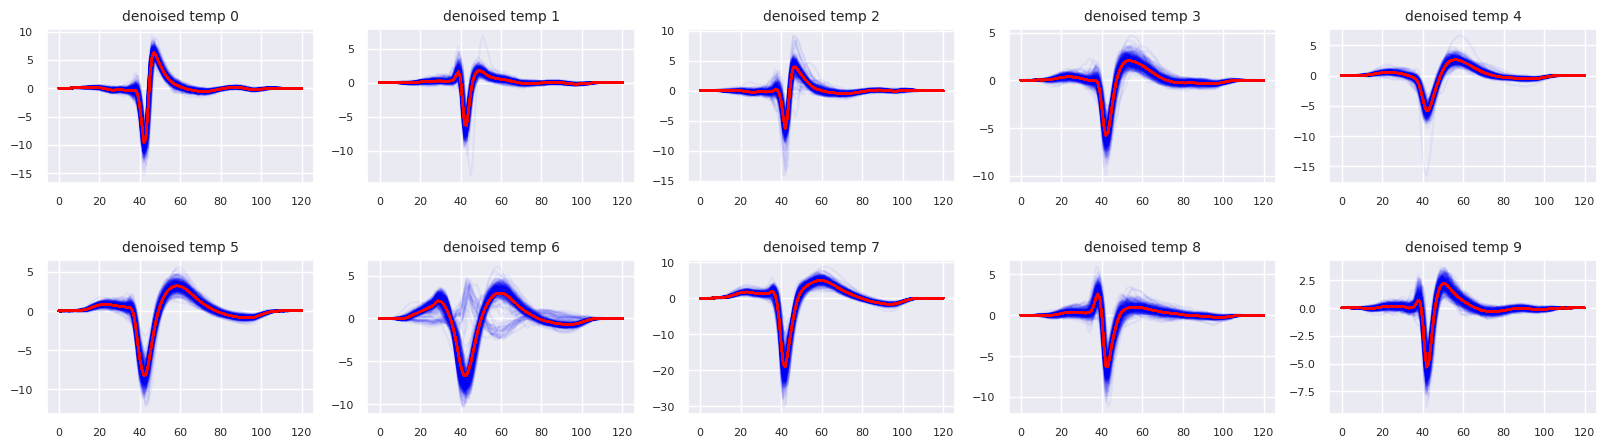

In [148]:
num_plot = 400
fig, axes = plt.subplots(2,5,figsize=(20,5))
for label_plot in range(len(np.unique(labels_train))):
    ax = axes[label_plot // 5][label_plot % 5]
    spikes = denoised_wfs_train[np.where(labels_train==label_plot)]
    for spike in spikes[:num_plot]:
        ax.plot(spike.flatten(), color='blue', alpha=.05)
        ax.plot(np.mean(spikes, 0).flatten(), color='red')
    ax.set_title(f'denoised temp {label_plot}')
fig.subplots_adjust(hspace=0.5)
plt.show()

Text(0, 0.5, 'raw pc2')

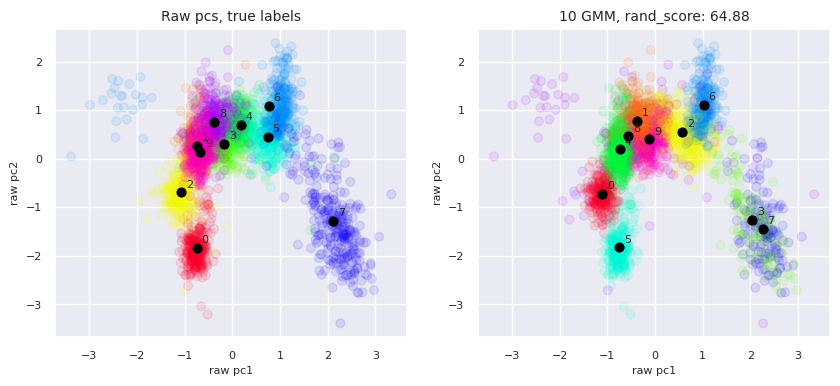

In [153]:
X = pcs_test
labels_pred = pc_test_labels
annotate_offset = .1
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].scatter(X[:, 0], X[:, 1], c=labels_test, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_test))):
    mean_location = np.mean(X[np.where(labels_test==label_plot)],0)
    axes[0].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[0].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
axes[0].set_title('Raw pcs, true labels')
axes[0].set_xlabel('raw pc1')
axes[0].set_ylabel('raw pc2')
axes[1].scatter(X[:, 0], X[:, 1], c=labels_pred, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_pred))):
    mean_location = np.mean(X[np.where(labels_pred==label_plot)],0)
    axes[1].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[1].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
score = adjusted_rand_score(labels_test, labels_pred)*100
axes[1].set_title(f'10 GMM, rand_score: {np.round(score,decimals=2)}');
axes[1].set_xlabel('raw pc1')
axes[1].set_ylabel('raw pc2')

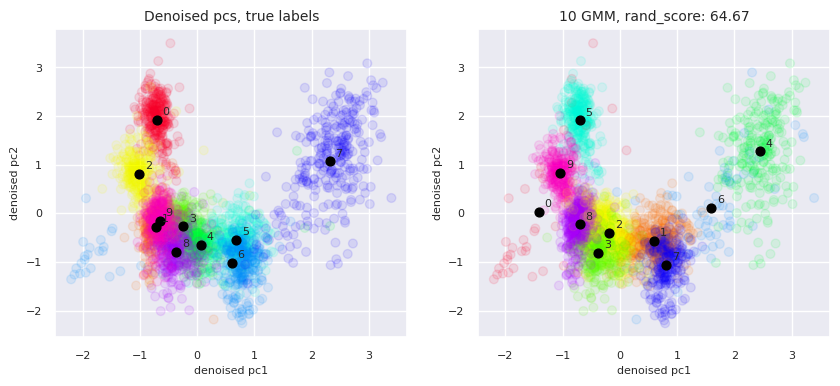

In [150]:
X = denoised_pcs_test
labels_pred = denoised_pc_test_labels
annotate_offset = .1
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].scatter(X[:, 0], X[:, 1], c=labels_test, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_test))):
    mean_location = np.mean(X[np.where(labels_test==label_plot)],0)
    axes[0].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[0].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
axes[0].set_title('Denoised pcs, true labels')
axes[0].set_xlabel('denoised pc1')
axes[0].set_ylabel('denoised pc2')
axes[1].scatter(X[:, 0], X[:, 1], c=labels_pred, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_pred))):
    mean_location = np.mean(X[np.where(labels_pred==label_plot)],0)
    axes[1].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[1].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
score = adjusted_rand_score(labels_test, labels_pred)*100
axes[1].set_title(f'10 GMM, rand_score: {np.round(score,decimals=2)}')
axes[1].set_xlabel('denoised pc1')
axes[1].set_ylabel('denoised pc2');

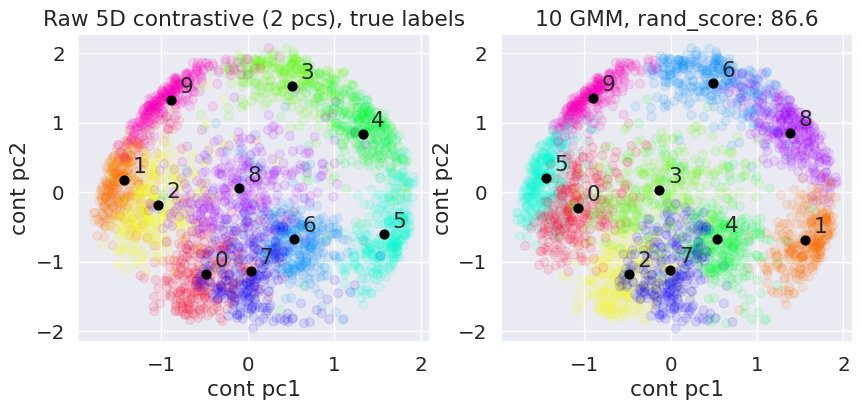

In [39]:
X = pcs_test_cont
labels_pred = gmm_cont_test_labels
annotate_offset = .1
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].scatter(X[:, 0], X[:, 1], c=labels_test, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_test))):
    mean_location = np.mean(X[np.where(labels_test==label_plot)],0)
    axes[0].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[0].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
axes[0].set_title('Raw 5D contrastive (2 pcs), true labels')
axes[0].set_xlabel('cont pc1')
axes[0].set_ylabel('cont pc2');
axes[1].scatter(X[:, 0], X[:, 1], c=labels_pred, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_pred))):
    mean_location = np.mean(X[np.where(labels_pred==label_plot)],0)
    axes[1].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[1].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
score = adjusted_rand_score(labels_test, labels_pred)*100
axes[1].set_title(f'10 GMM, rand_score: {np.round(score,decimals=2)}');
axes[1].set_xlabel('cont pc1')
axes[1].set_ylabel('cont pc2');

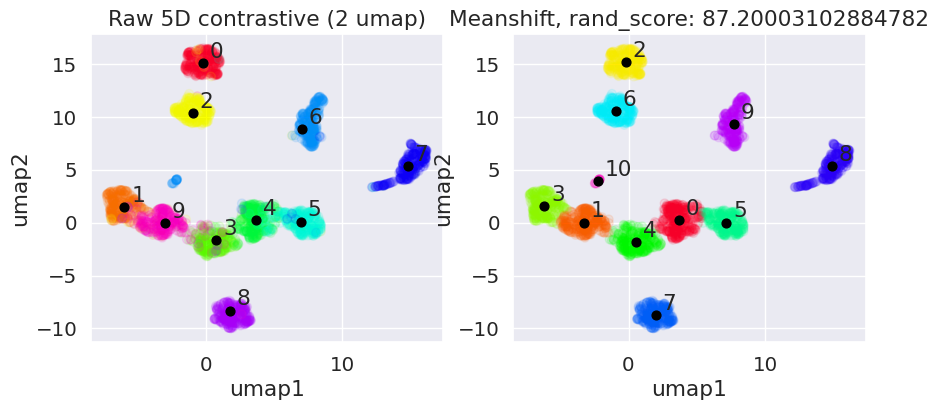

In [40]:
X = cont_test_umap
labels_pred = labels_test_ms
annotate_offset = .5
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].scatter(X[:, 0], X[:, 1], c=labels_test, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_test))):
    mean_location = np.mean(X[np.where(labels_test==label_plot)],0)
    axes[0].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[0].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
axes[0].set_title('Raw 5D contrastive (2 umap)')
axes[0].set_xlabel('umap1')
axes[0].set_ylabel('umap2');
axes[1].scatter(X[:, 0], X[:, 1], c=labels_pred, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_pred))):
    mean_location = np.mean(X[np.where(labels_pred==label_plot)],0)
    axes[1].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[1].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
score = adjusted_rand_score(labels_test, labels_pred)*100
axes[1].set_title(f'Meanshift, rand_score: {score}');
axes[1].set_xlabel('umap1')
axes[1].set_ylabel('umap2');

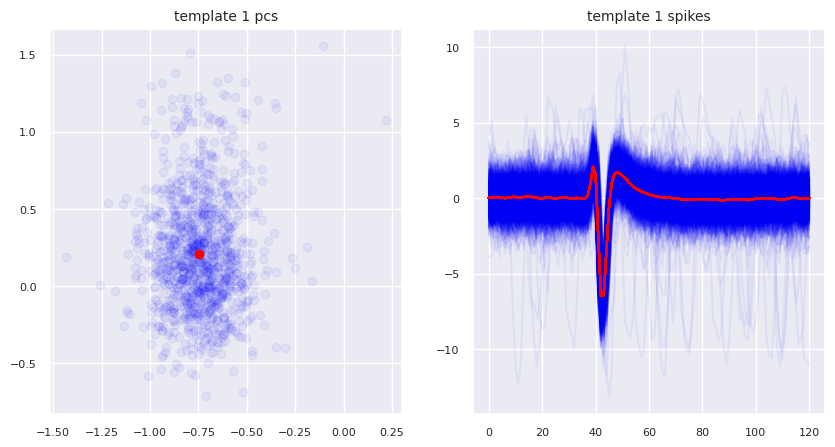

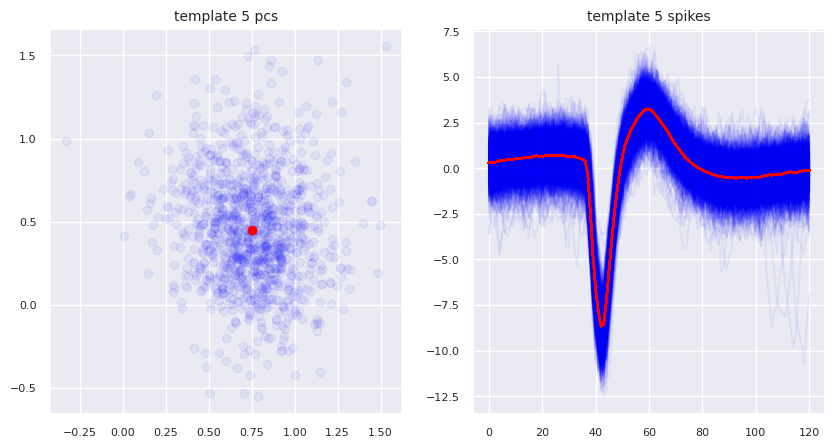

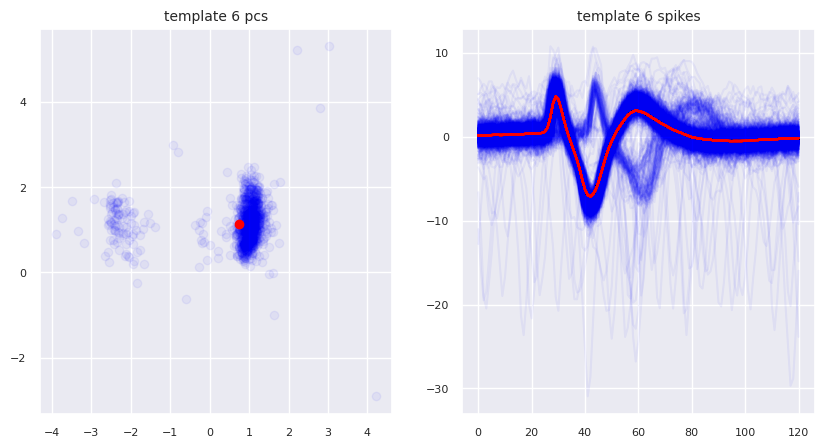

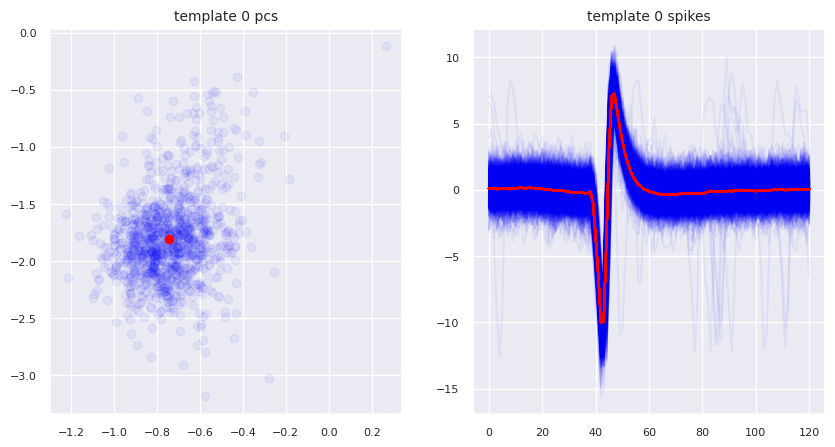

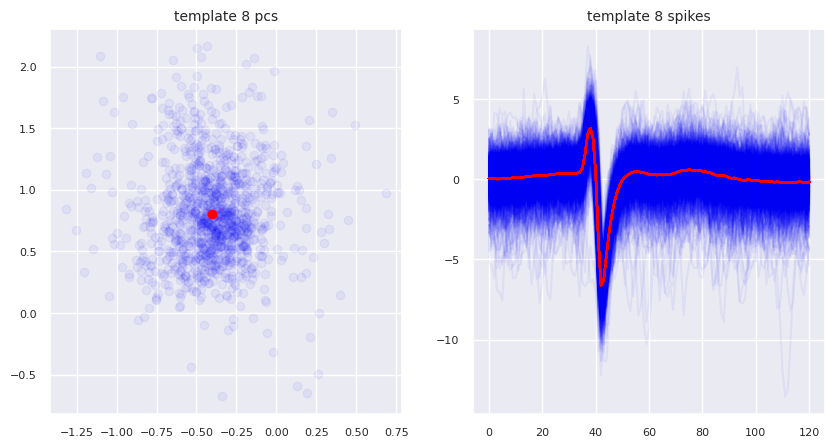

In [159]:
num_plot = 1200
units_plot = [1, 5, 6, 0, 8]
for label_plot in units_plot:#range(len(np.unique(labels_train))):
    fig, axes = plt.subplots(1,2,figsize=(10,5))
    pcs = pcs_train[np.where(labels_train==label_plot)][:num_plot]
    axes[0].scatter(pcs[:,0], pcs[:,1], color='blue', alpha=.05)
    axes[0].scatter(np.mean(pcs,0)[0], np.mean(pcs,0)[1], color='red', alpha=1)
    spikes = wfs_train[np.where(labels_train==label_plot)]
    for spike in spikes[:num_plot]:
        axes[1].plot(spike.flatten(), color='blue', alpha=.05)
        axes[1].plot(np.mean(spikes, 0).flatten(), color='red')
    axes[0].set_title(f'template {label_plot} pcs')
    axes[1].set_title(f'template {label_plot} spikes')
    plt.show()

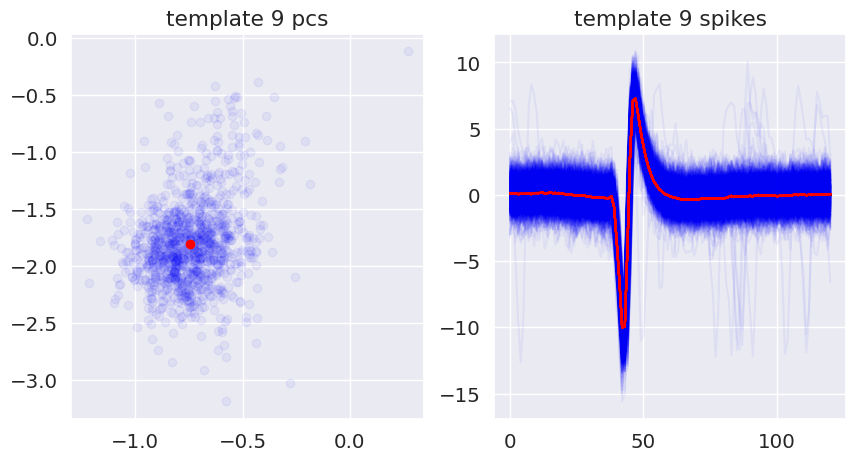

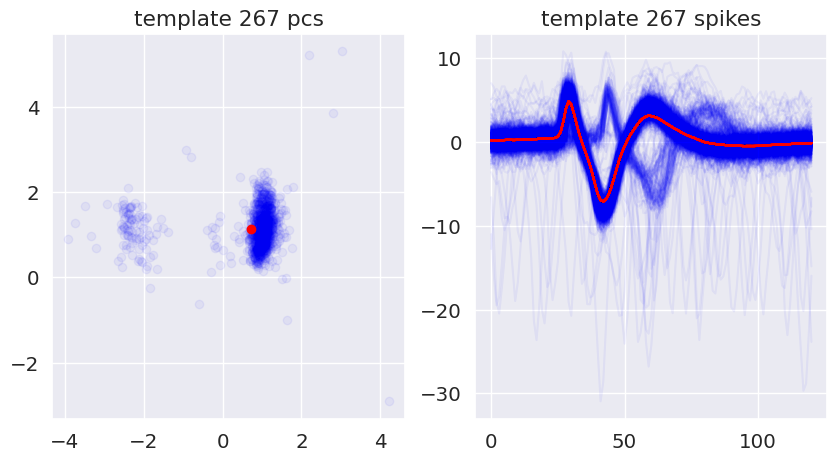

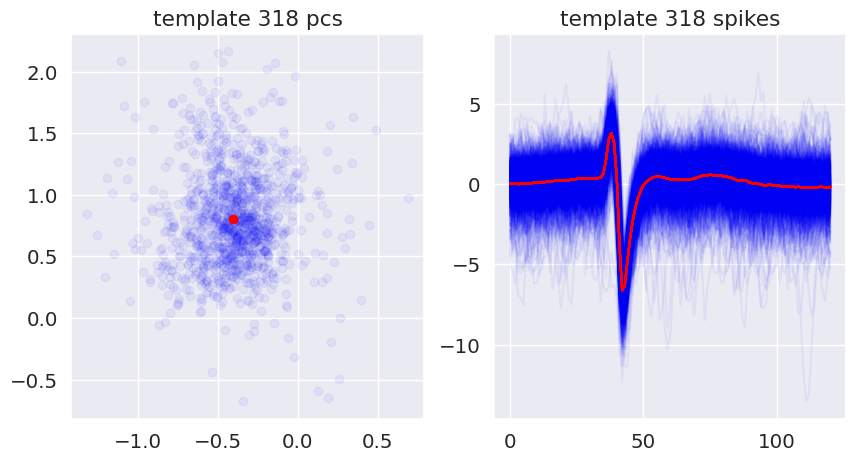

In [58]:
num_plot = 1200
units_plot = [0, 8]
for label_plot in units_plot:#range(len(np.unique(labels_train))):
    fig, axes = plt.subplots(1,2,figsize=(10,5))
    pcs = pcs_train[np.where(labels_train==label_plot)][:num_plot]
    axes[0].scatter(pcs[:,0], pcs[:,1], color='blue', alpha=.05)
    axes[0].scatter(np.mean(pcs,0)[0], np.mean(pcs,0)[1], color='red', alpha=1)
    spikes = wfs_train[np.where(labels_train==label_plot)]
    for spike in spikes[:num_plot]:
        axes[1].plot(spike.flatten(), color='blue', alpha=.05)
        axes[1].plot(np.mean(spikes, 0).flatten(), color='red')
    axes[0].set_title(f'template {label_plot} pcs')
    axes[1].set_title(f'template {label_plot} spikes')
    plt.show()

In [42]:
# X_pca = learn_manifold_umap(denoised_pcs_test, umap_dim=2, umap_min_dist=0.2, umap_metric='euclidean', umap_neighbors=10)
# clustering = MeanShift(bandwidth=2, n_jobs=20).fit(X_pca)
# labels_test_ms_pcs = clustering.predict(X_pca)
# score = adjusted_rand_score(labels_test, labels_test_ms_pcs)*100

In [43]:
# fig, axes = plt.subplots(1,2,figsize=(10,4))
# # X = pcs_test
# axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_test, s=40, cmap='gist_rainbow', zorder=2, alpha=.5)
# axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_test_ms_pcs, s=40, cmap='gist_rainbow', zorder=2, alpha=.5)
# axes[0].set_title('True')
# axes[1].set_title(f'Predicted, rand_score: {score}');

In [44]:
# reps_train = pcs_train
# reps_test = pcs_test
# for num_c in np.arange(2, denoised_pcs_train.shape[1]+1):
#     gm = GaussianMixture(model_params['n_clusters'], 
#                          random_state=0, 
#                          covariance_type='full').fit(reps_train[:,:num_c])
#     test_labels = gm.predict(reps_test[:,:num_c])
#     score = adjusted_rand_score(labels_test, test_labels)*100
#     print(f"num_comps: {num_c}, rand_score: {score}")

In [45]:
# train_list = [pcs_train[:,:2], denoised_pcs_train[:,:2], pcs_train[:,:5], denoised_pcs_train[:,:5]]
# test_list = [pcs_test[:,:2], denoised_pcs_test[:,:2], pcs_test[:,:5], denoised_pcs_test[:,:5]]

# cluster_method = 'GMM'
# models = [f'{cluster_method} Single-chan, num pcs: {train_list[0].shape[1]}', 
#           f'{cluster_method} Denoised single-chan, num pcs: {train_list[1].shape[1]}',
#           f'{cluster_method} Single-chan, num pcs: {train_list[2].shape[1]}',
#           f'{cluster_method} Denoised single-chan, num pcs: {train_list[3].shape[1]}'] 

# num_classes = len(np.unique(labels_test))
# model_params = {'n_clusters':15, 'min_cluster_size':20}
# per_class_map = per_class_accs(train_list, test_list, models, num_classes, cluster_method.lower(), unit_ids, model_params)
# avg_class_map = avg_class_accs(train_list, test_list, models, num_classes, cluster_method.lower(), model_params)

# pc_df = pd.DataFrame.from_dict(per_class_map, 'index')
# ac_df = pd.DataFrame.from_dict(avg_class_map)

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     display(pc_df)
    
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     display(ac_df)